In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

## Data Collection

#### short term interest rate

In [58]:
stir = pd.read_csv('var/short_term_int_rate_q.csv')

In [59]:
stir = stir[['TIME', 'Value']].copy()

In [60]:
stir['date'] = pd.to_datetime(stir['TIME'])

#### inflation rate

In [61]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()
ir = ir[:-9]
ir = [float(ir[i]) for i in range(len(ir))]
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

In [62]:
ir = ir.iloc[:-3, :].copy()

In [63]:
ir['date'] = ir['TIME'].map(lambda x: pd.Period(x,'Q'))

In [64]:
ir = ir[['date', 'Value']].copy()

In [65]:
ir['Value'] = ir['Value'].astype(float)

In [66]:
ir['date'] = ir['date'].astype(str)

In [67]:
quarters = pd.unique(ir['date']).tolist()

In [68]:
g = ir.groupby('date')['Value']

In [69]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [70]:
ir = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [71]:
gdp = pd.read_csv('var/gdp_m_q.csv')

In [72]:
gdp = gdp[
    gdp['Subject']=='National Accounts > GDP by Expenditure > Constant Prices > Gross Domestic Product - Total'
].copy()

In [73]:
gdp = gdp[gdp['Measure']=='Level, rate or national currency, s.a.'].copy()

In [74]:
gdp = gdp[gdp['FREQUENCY']=='Q'].copy()

In [75]:
gdp = gdp[['Subject', 'Measure', 'FREQUENCY', 'TIME', 'Time', 'Unit Code', 'Value']].copy()

In [76]:
gdp = gdp.reset_index(drop=True)

In [77]:
gdp = gdp[['TIME', 'Value']].copy()

In [78]:
gdp['date'] = pd.to_datetime(gdp['TIME']).tolist()

#### Make full DF

In [79]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()

In [80]:
stir.index = stir['date']
stir = stir[['Value']].copy()

In [81]:
ir.index = ir['date']
ir = ir[['Value']].copy()

In [82]:
df_var_t = pd.concat([gdp, stir, ir], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                   1.137740
p-value                          0.995526
#Lags Used                       2.000000
Number of Observations Used    207.000000
Critical Value (5%)             -2.875606
Critical Value (10%)            -2.574267
Critical Value (1%)             -3.462342
dtype: float64


Results of KPSS Test:
Test Statistic            1.407291
p-value                   0.010000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


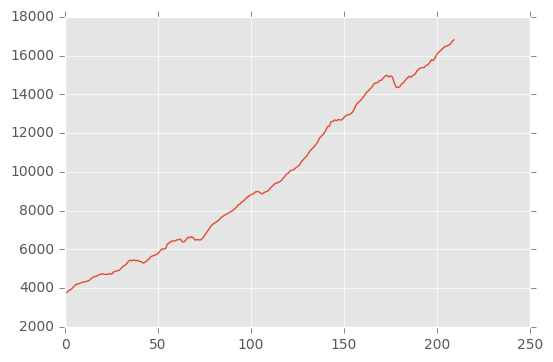

In [83]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.754592
p-value                          0.403227
#Lags Used                       7.000000
Number of Observations Used    202.000000
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
Critical Value (1%)             -3.463144
dtype: float64


Results of KPSS Test:
Test Statistic            0.805212
p-value                   0.010000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


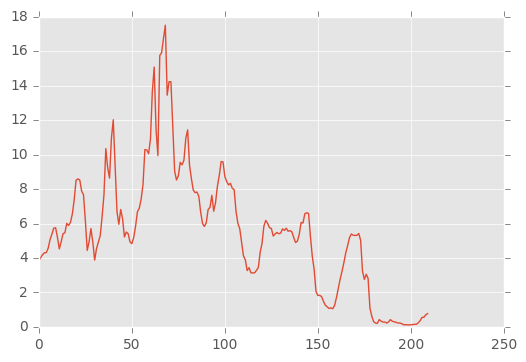

In [84]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.628578
p-value                          0.468235
#Lags Used                      12.000000
Number of Observations Used    197.000000
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
Critical Value (1%)             -3.463987
dtype: float64


Results of KPSS Test:
Test Statistic            0.627924
p-value                   0.020098
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


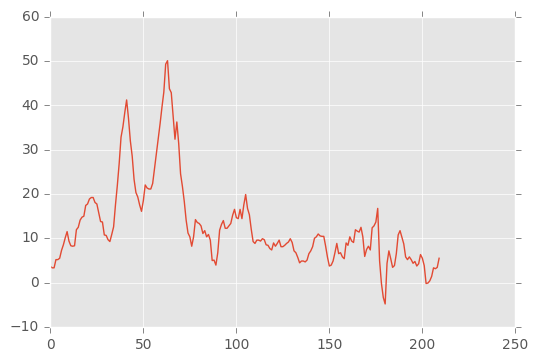

In [85]:
test_stationarity(df_var_t['infr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                -6.729151e+00
p-value                        3.330094e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.070000e+02
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
Critical Value (1%)           -3.462342e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.305495
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


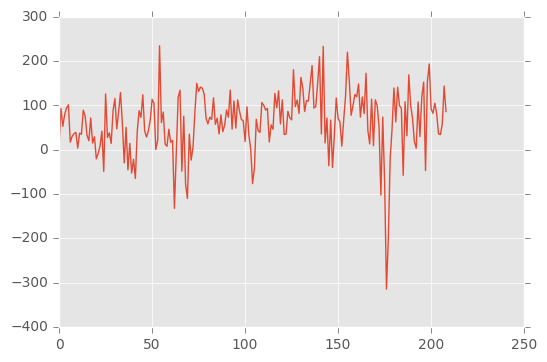

In [86]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -5.919963e+00
p-value                        2.520096e-07
#Lags Used                     6.000000e+00
Number of Observations Used    2.020000e+02
Critical Value (5%)           -2.875957e+00
Critical Value (10%)          -2.574455e+00
Critical Value (1%)           -3.463144e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.120741
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


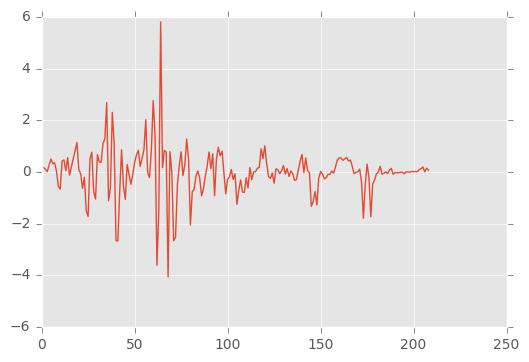

In [87]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.493664
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    193.000000
Critical Value (5%)             -2.876635
Critical Value (10%)            -2.574816
Critical Value (1%)             -3.464694
dtype: float64


Results of KPSS Test:
Test Statistic            0.110707
p-value                   0.100000
#Lags Used               15.000000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


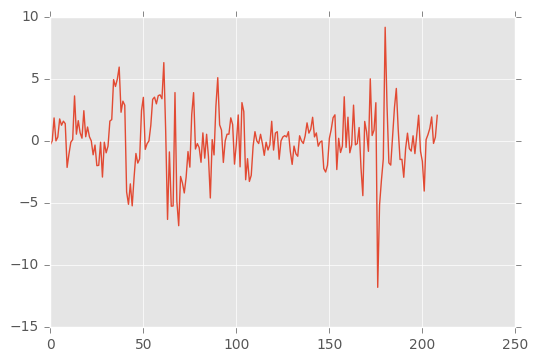

In [88]:
test_stationarity(diff_series(df_var_t['infr']))

In [89]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [90]:
STEPS = 6
LAG = 2

In [91]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [92]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [93]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mae': 0.1179240988352072, 'mse': 0.024856561493472758, 'rmse': 0.15765963812426045}
{'mae': 0.98635473090454051, 'mse': 1.4694001991209049, 'rmse': 1.2121881863476911}
{'mae': 34.555080853786556, 'mse': 1790.1328625148171, 'rmse': 42.309961740881036}


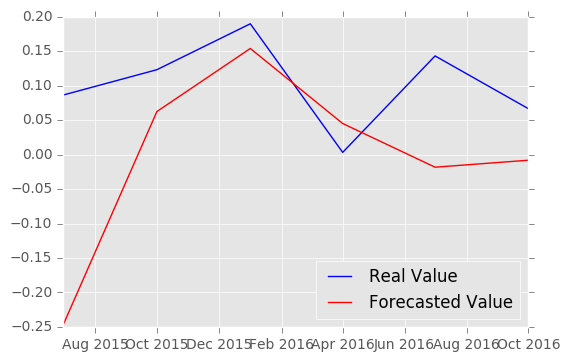

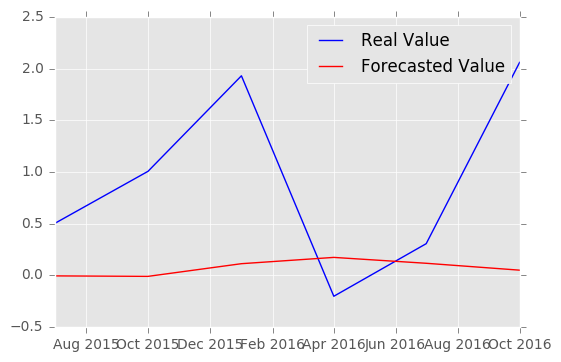

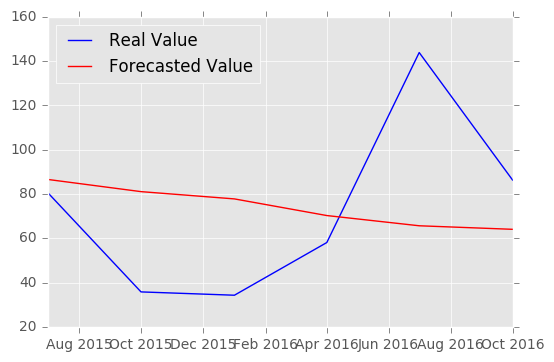

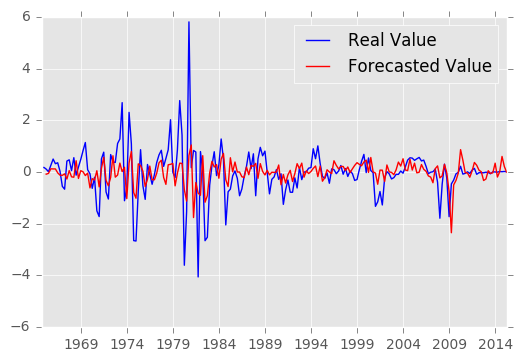

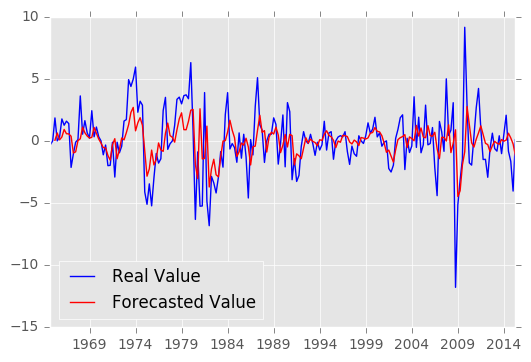

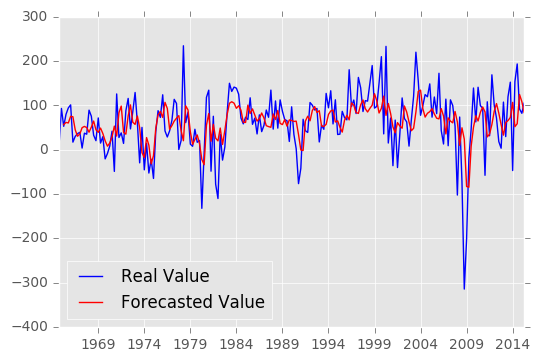

In [94]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mae': 0.45264744728791378, 'mse': 0.2150923778268187, 'rmse': 0.4637805276494677}
{'mae': 2.7764672872035949, 'mse': 9.8636417515662753, 'rmse': 3.1406435250703439}
{'mae': 48.940585444887496, 'mse': 3983.1009813954092, 'rmse': 63.111813326788585}


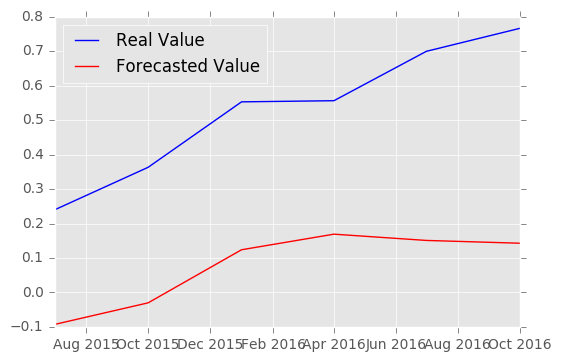

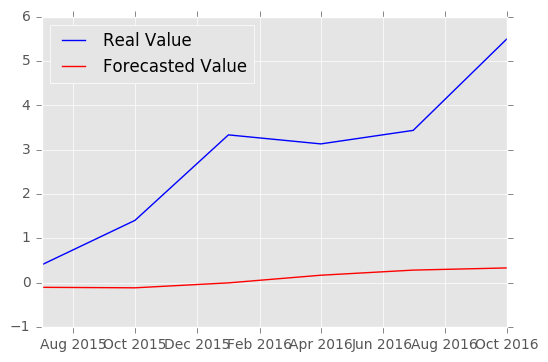

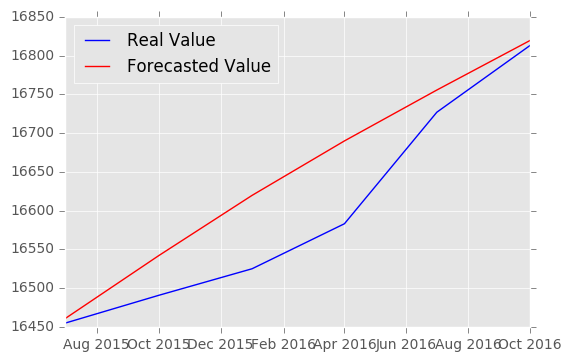

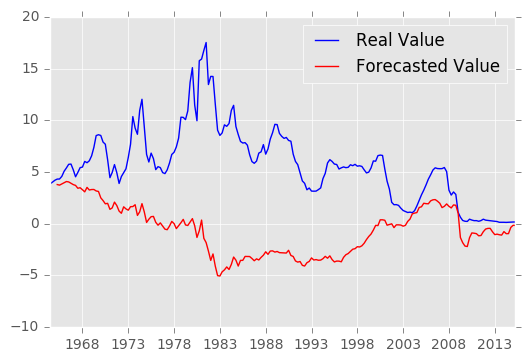

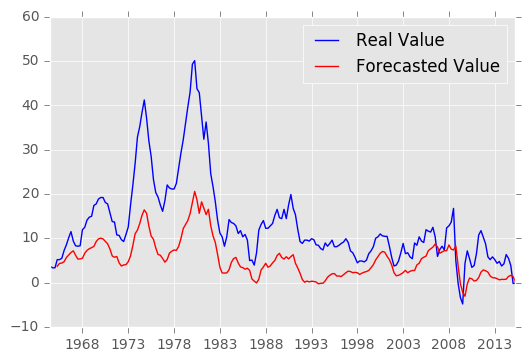

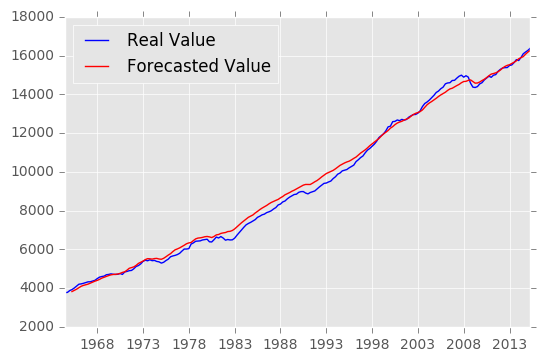

In [95]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [96]:
df_nn = nn_transform(train, n=LAG)

In [97]:
df_nn_s, m, s = scaler(df_nn)

In [98]:
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [99]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [100]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [101]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0701
Epoch 2/600
0s - loss: 0.9975
Epoch 3/600
0s - loss: 0.9863
Epoch 4/600
0s - loss: 0.9749
Epoch 5/600
0s - loss: 0.9707
Epoch 6/600
0s - loss: 0.9607
Epoch 7/600
0s - loss: 0.9528
Epoch 8/600
0s - loss: 0.9450
Epoch 9/600
0s - loss: 0.9388
Epoch 10/600
0s - loss: 0.9339
Epoch 11/600
0s - loss: 0.9259
Epoch 12/600
0s - loss: 0.9191
Epoch 13/600
0s - loss: 0.9114
Epoch 14/600
0s - loss: 0.9091
Epoch 15/600
0s - loss: 0.9012
Epoch 16/600
0s - loss: 0.8963
Epoch 17/600
0s - loss: 0.8882
Epoch 18/600
0s - loss: 0.8845
Epoch 19/600
0s - loss: 0.8791
Epoch 20/600
0s - loss: 0.8754
Epoch 21/600
0s - loss: 0.8684
Epoch 22/600
0s - loss: 0.8641
Epoch 23/600
0s - loss: 0.8597
Epoch 24/600
0s - loss: 0.8542
Epoch 25/600
0s - loss: 0.8495
Epoch 26/600
0s - loss: 0.8468
Epoch 27/600
0s - loss: 0.8430
Epoch 28/600
0s - loss: 0.8402
Epoch 29/600
0s - loss: 0.8348
Epoch 30/600
0s - loss: 0.8317
Epoch 31/600
0s - loss: 0.8300
Epoch 32/600
0s - loss: 0.8254
Epoch 33/600
0s -

In [102]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

{'mae': 0.78238334358289785, 'mse': 0.95195091384169384, 'rmse': 0.9756797188840679}
{'mae': 1.5203491983805122, 'mse': 4.2601253783556237, 'rmse': 2.0640071168374452}
{'mae': 41.487803996930502, 'mse': 3127.7714975793056, 'rmse': 55.926482971659368}


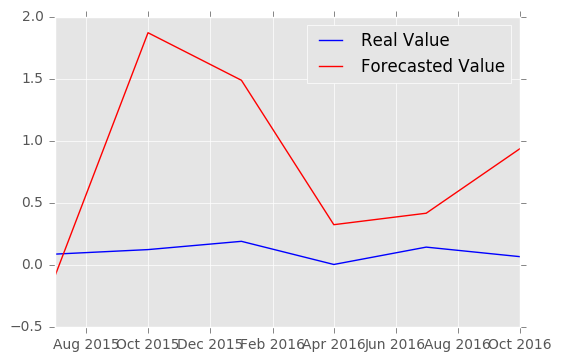

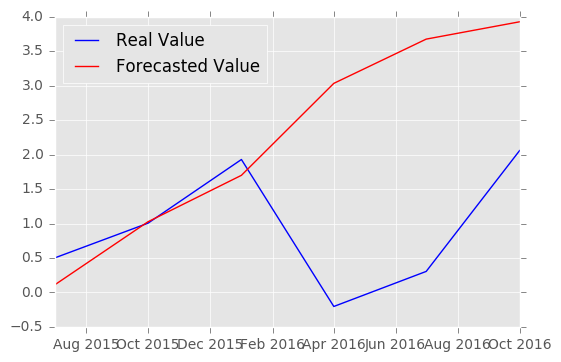

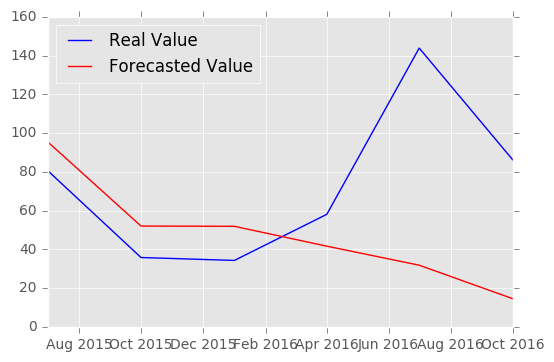

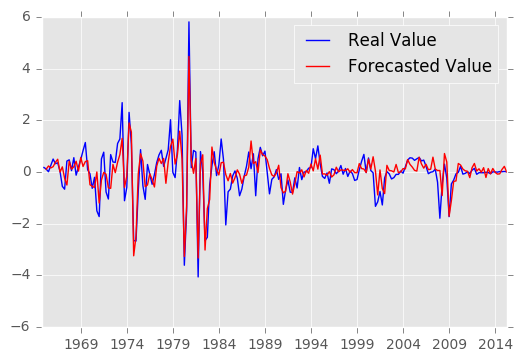

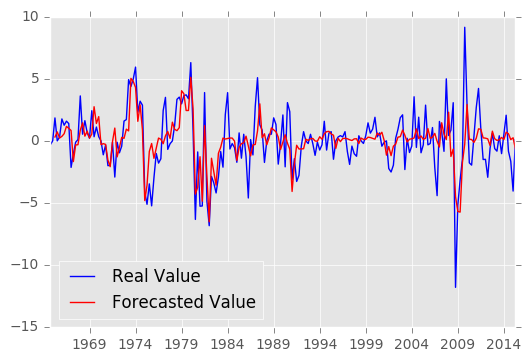

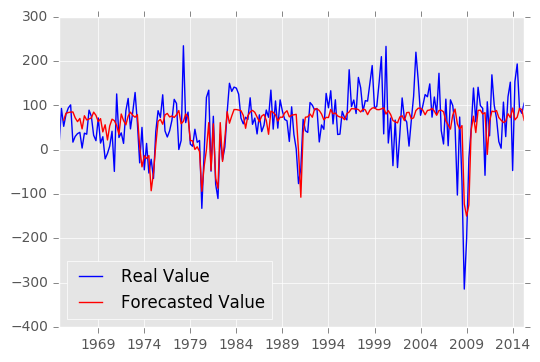

In [103]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 2.5972214457738945, 'mse': 8.5856796218187643, 'rmse': 2.9301330382456636}
{'mae': 2.9818670958976514, 'mse': 17.63741013393091, 'rmse': 4.1996916712933716}
{'mae': 59.7066732247525, 'mse': 5654.3575025179307, 'rmse': 75.195461980879742}


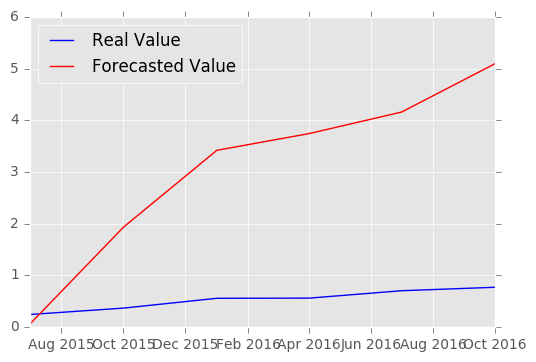

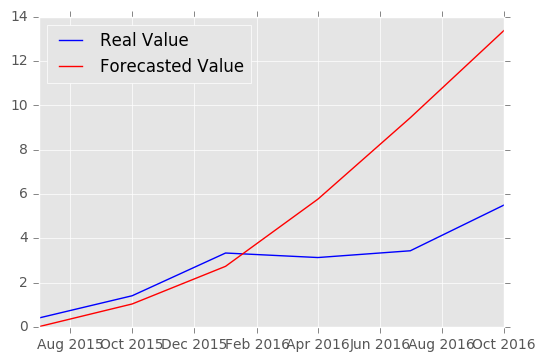

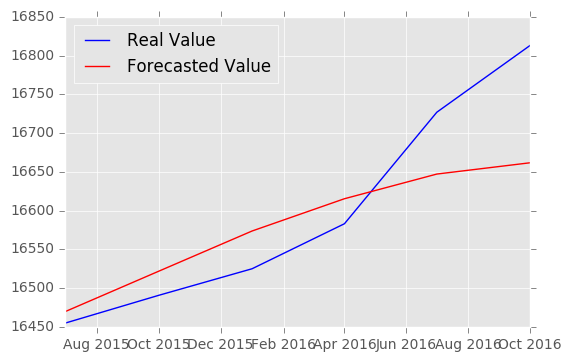

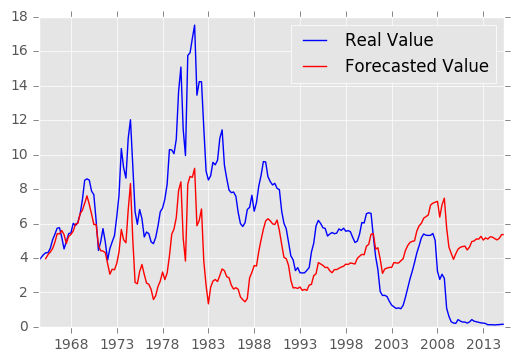

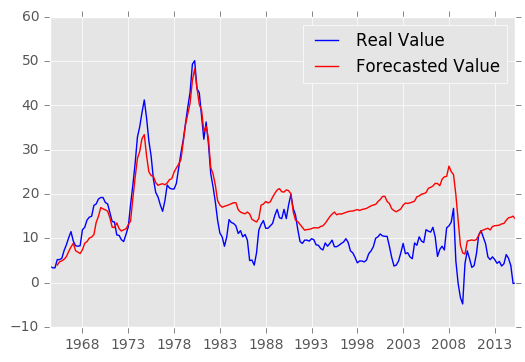

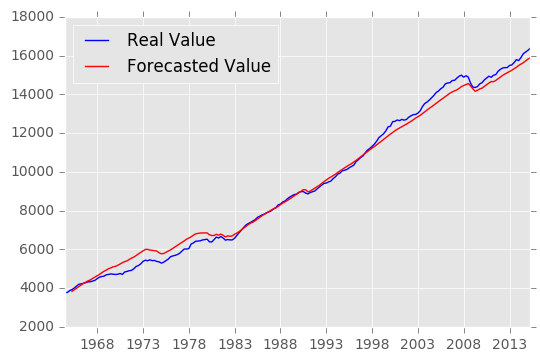

In [104]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [105]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1423
Epoch 2/600
0s - loss: 0.9910
Epoch 3/600
0s - loss: 0.9733
Epoch 4/600
0s - loss: 0.9640
Epoch 5/600
0s - loss: 0.9568
Epoch 6/600
0s - loss: 0.9451
Epoch 7/600
0s - loss: 0.9375
Epoch 8/600
0s - loss: 0.9293
Epoch 9/600
0s - loss: 0.9213
Epoch 10/600
0s - loss: 0.9110
Epoch 11/600
0s - loss: 0.9068
Epoch 12/600
0s - loss: 0.8993
Epoch 13/600
0s - loss: 0.8911
Epoch 14/600
0s - loss: 0.8866
Epoch 15/600
0s - loss: 0.8793
Epoch 16/600
0s - loss: 0.8749
Epoch 17/600
0s - loss: 0.8679
Epoch 18/600
0s - loss: 0.8625
Epoch 19/600
0s - loss: 0.8578
Epoch 20/600
0s - loss: 0.8519
Epoch 21/600
0s - loss: 0.8496
Epoch 22/600
0s - loss: 0.8460
Epoch 23/600
0s - loss: 0.8428
Epoch 24/600
0s - loss: 0.8391
Epoch 25/600
0s - loss: 0.8350
Epoch 26/600
0s - loss: 0.8319
Epoch 27/600
0s - loss: 0.8293
Epoch 28/600
0s - loss: 0.8264
Epoch 29/600
0s - loss: 0.8241
Epoch 30/600
0s - loss: 0.8216
Epoch 31/600
0s - loss: 0.8194
Epoch 32/600
0s - loss: 0.8158
Epoch 33/600
0s -

{'mae': 0.18420504072680288, 'mse': 0.067835414535496824, 'rmse': 0.26045232679992864}
{'mae': 1.0054400816135347, 'mse': 1.4778226570362147, 'rmse': 1.2156572942388881}
{'mae': 36.53978162908745, 'mse': 1861.8602694976119, 'rmse': 43.149278898929609}


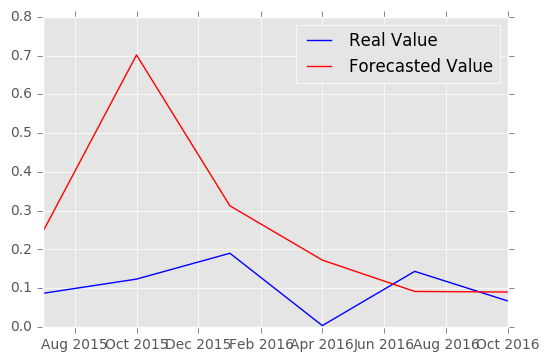

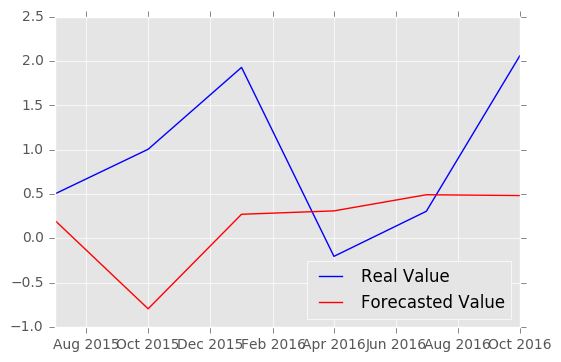

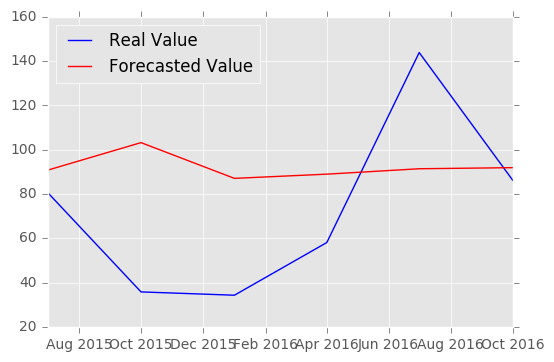

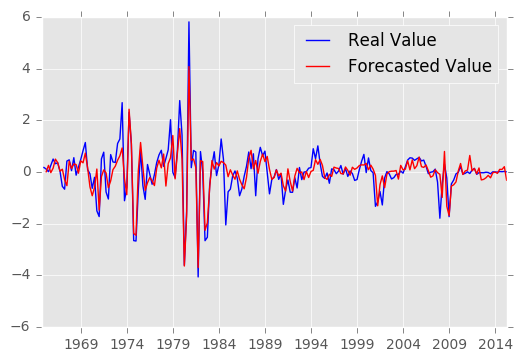

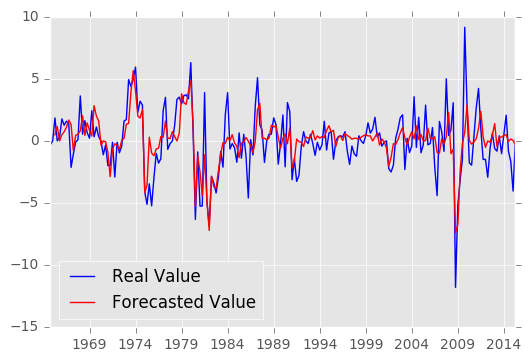

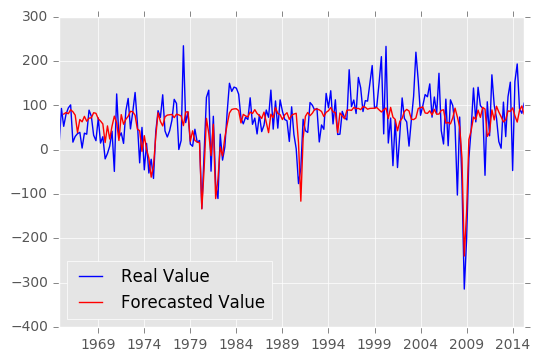

In [106]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.79492865335314011, 'mse': 0.72224398129809975, 'rmse': 0.84984938741997085}
{'mae': 2.8468802106771824, 'mse': 9.9851918744580441, 'rmse': 3.1599354225138914}
{'mae': 100.3241112708062, 'mse': 12319.243209238701, 'rmse': 110.99208624599639}


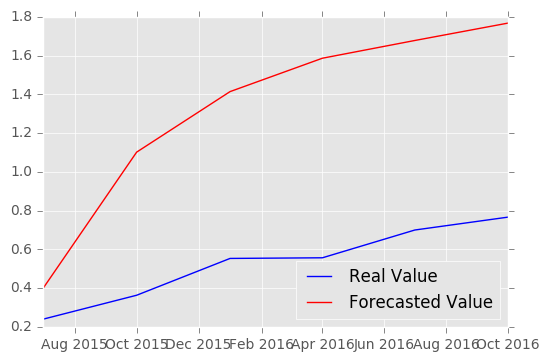

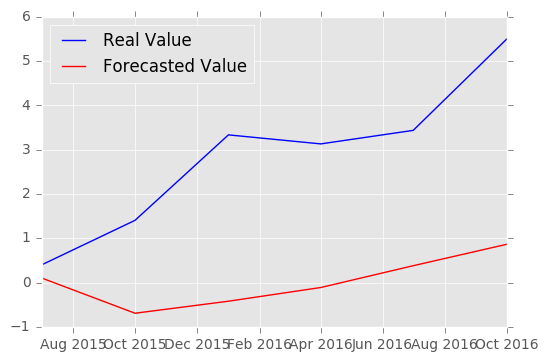

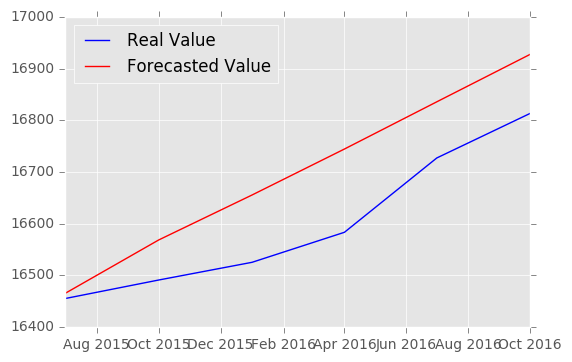

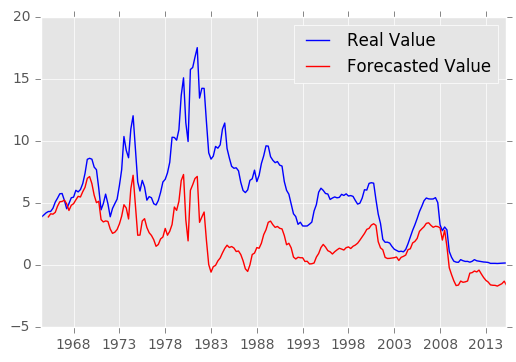

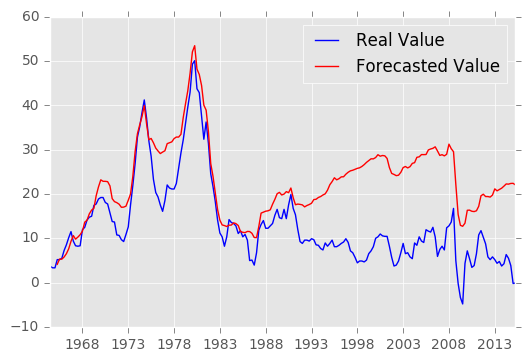

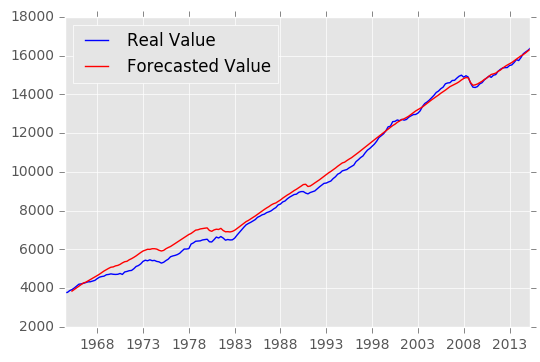

In [107]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [108]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.0814
Epoch 2/600
0s - loss: 1.0121
Epoch 3/600
0s - loss: 1.0144
Epoch 4/600
0s - loss: 0.9978
Epoch 5/600
0s - loss: 1.0052
Epoch 6/600
0s - loss: 1.0039
Epoch 7/600
0s - loss: 0.9854
Epoch 8/600
0s - loss: 0.9989
Epoch 9/600
0s - loss: 0.9942
Epoch 10/600
0s - loss: 0.9945
Epoch 11/600
0s - loss: 0.9905
Epoch 12/600
0s - loss: 0.9915
Epoch 13/600
0s - loss: 0.9841
Epoch 14/600
0s - loss: 0.9859
Epoch 15/600
0s - loss: 0.9892
Epoch 16/600
0s - loss: 0.9916
Epoch 17/600
0s - loss: 0.9864
Epoch 18/600
0s - loss: 0.9815
Epoch 19/600
0s - loss: 0.9786
Epoch 20/600
0s - loss: 0.9785
Epoch 21/600
0s - loss: 0.9832
Epoch 22/600
0s - loss: 0.9710
Epoch 23/600
0s - loss: 0.9782
Epoch 24/600
0s - loss: 0.9695
Epoch 25/600
0s - loss: 0.9609
Epoch 26/600
0s - loss: 0.9757
Epoch 27/600
0s - loss: 0.9577
Epoch 28/600
0s - loss: 0.9516
Epoch 29/600
0s - loss: 0.9692
Epoch 30/600
0s - loss: 0.9519
Epoch 31/600
0s - loss: 0.9484
Epoch 32/600
0s - loss: 0.9412
Epoch 33/600
0s -

{'mae': 0.053786366653067484, 'mse': 0.0043772808439572087, 'rmse': 0.066161022089725977}
{'mae': 0.8760744425834387, 'mse': 1.1757602014275605, 'rmse': 1.0843247675062857}
{'mae': 36.60392479738212, 'mse': 1821.0586088858715, 'rmse': 42.67386329928275}


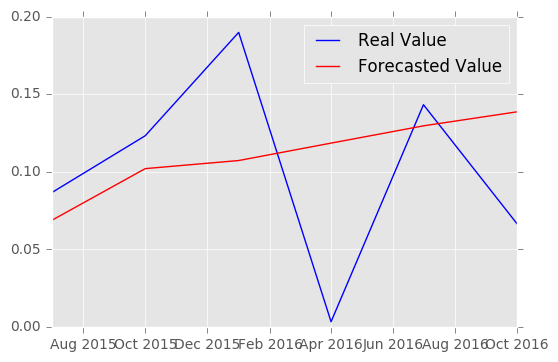

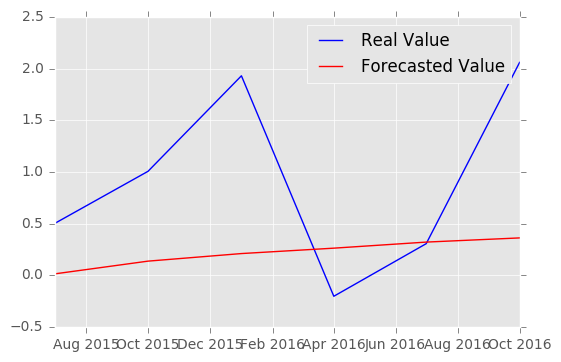

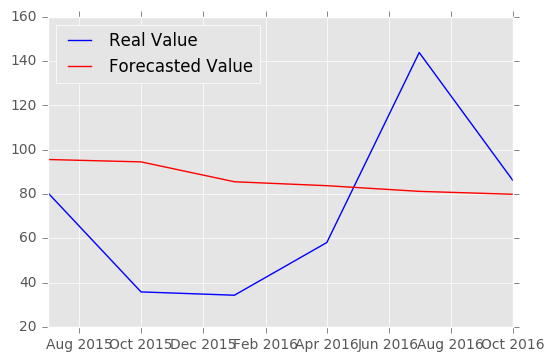

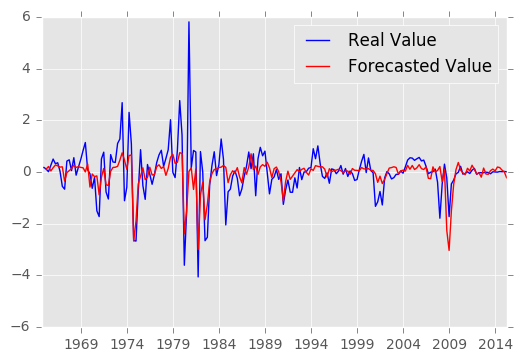

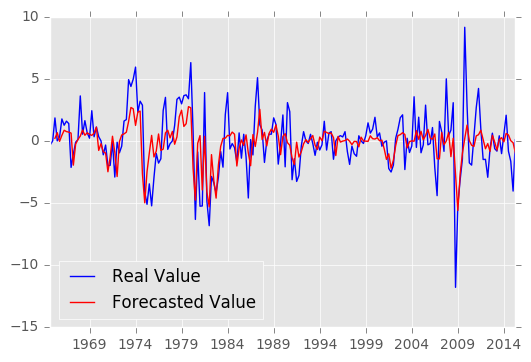

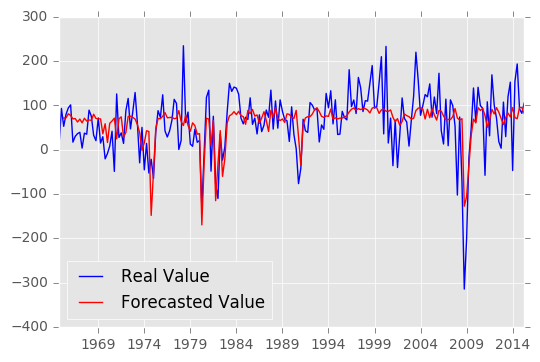

In [109]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 0.042904079856793113, 'mse': 0.0033042414314684212, 'rmse': 0.057482531533226869}
{'mae': 2.4040624331799036, 'mse': 7.2590734268133517, 'rmse': 2.6942667697934723}
{'mae': 88.868838216851756, 'mse': 9707.4678585986967, 'rmse': 98.526483031714349}


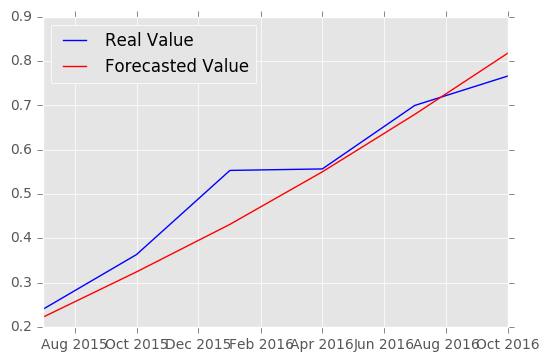

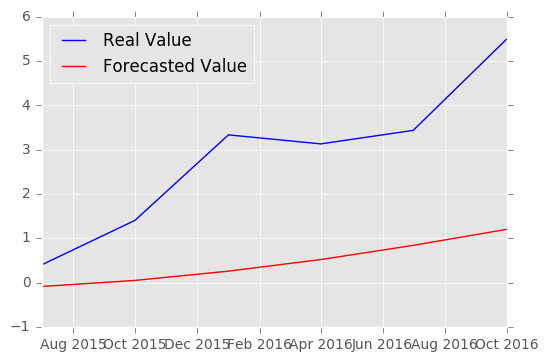

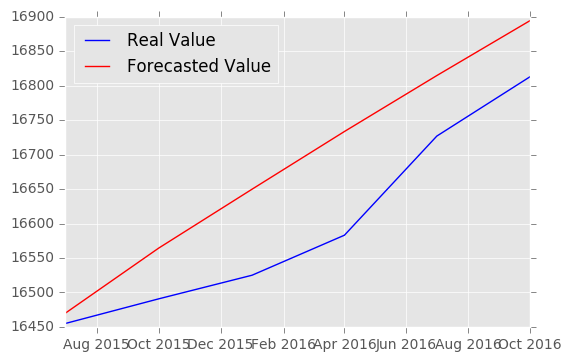

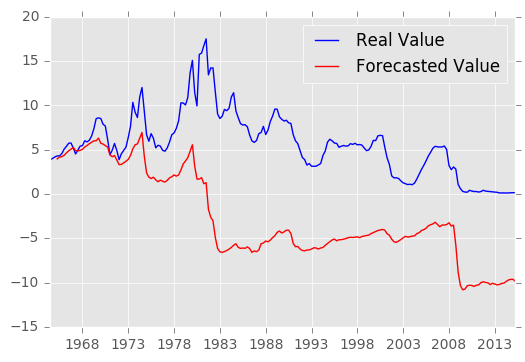

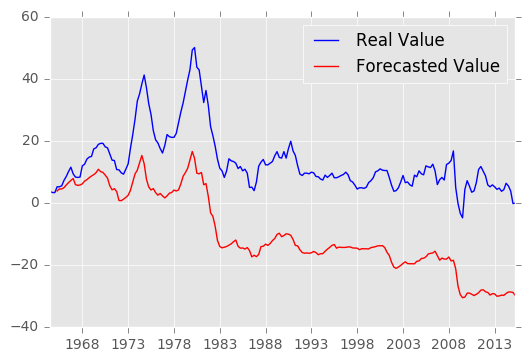

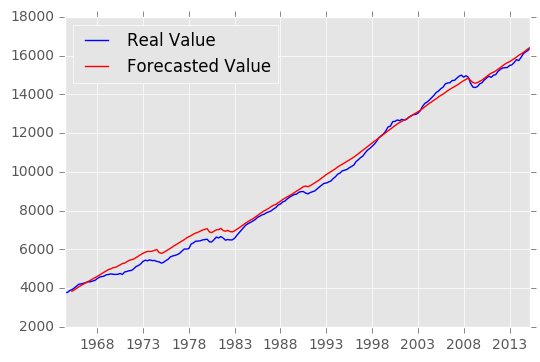

In [110]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [111]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [112]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 0.9286
Epoch 2/600
0s - loss: 0.7477
Epoch 3/600
0s - loss: 0.5824
Epoch 4/600
0s - loss: 0.4411
Epoch 5/600
0s - loss: 0.3505
Epoch 6/600
0s - loss: 0.2999
Epoch 7/600
0s - loss: 0.2674
Epoch 8/600
0s - loss: 0.2451
Epoch 9/600
0s - loss: 0.2228
Epoch 10/600
0s - loss: 0.2041
Epoch 11/600
0s - loss: 0.1883
Epoch 12/600
0s - loss: 0.1722
Epoch 13/600
0s - loss: 0.1616
Epoch 14/600
0s - loss: 0.1510
Epoch 15/600
0s - loss: 0.1412
Epoch 16/600
0s - loss: 0.1325
Epoch 17/600
0s - loss: 0.1243
Epoch 18/600
0s - loss: 0.1162
Epoch 19/600
0s - loss: 0.1106
Epoch 20/600
0s - loss: 0.1028
Epoch 21/600
0s - loss: 0.0955
Epoch 22/600
0s - loss: 0.0899
Epoch 23/600
0s - loss: 0.0847
Epoch 24/600
0s - loss: 0.0787
Epoch 25/600
0s - loss: 0.0741
Epoch 26/600
0s - loss: 0.0705
Epoch 27/600
0s - loss: 0.0671
Epoch 28/600
0s - loss: 0.0641
Epoch 29/600
0s - loss: 0.0613
Epoch 30/600
0s - loss: 0.0591
Epoch 31/600
0s - loss: 0.0582
Epoch 32/600
0s - loss: 0.0563
Epoch 33/600
0s -

{'mae': 4.8014912657296636, 'mse': 28.152721691830951, 'rmse': 5.3059138413501357}
{'mae': 10.490278403346695, 'mse': 178.18800721019727, 'rmse': 13.348708072701166}
{'mae': 1286.3120539617919, 'mse': 1817537.4491756198, 'rmse': 1348.1607653301662}


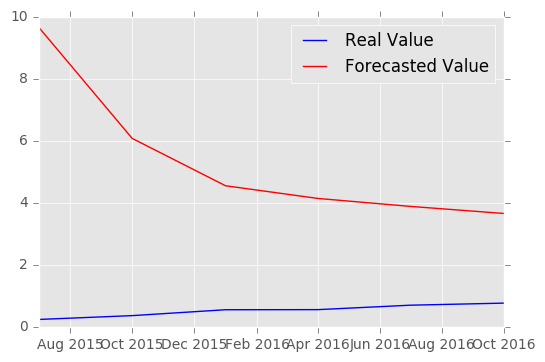

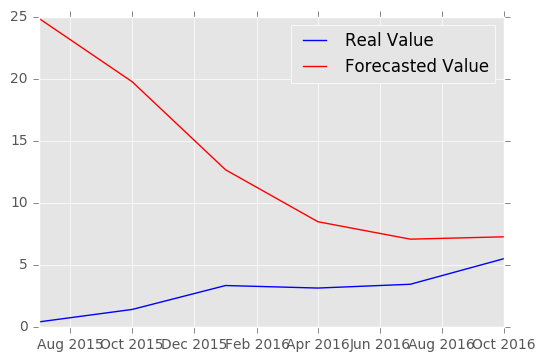

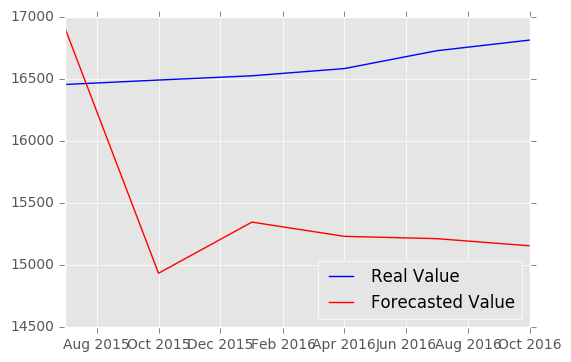

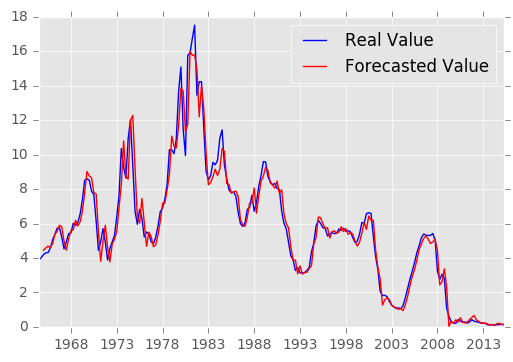

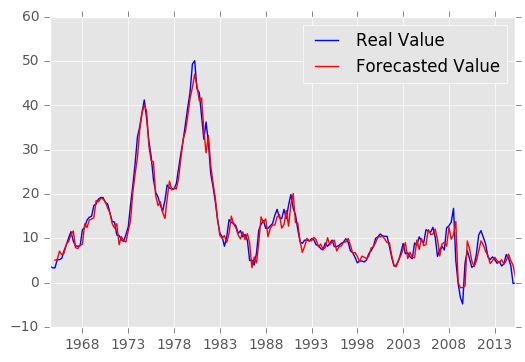

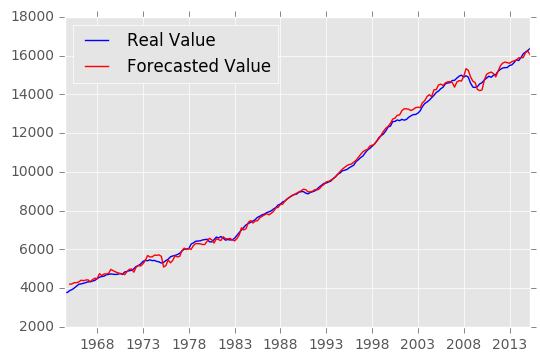

In [113]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [114]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1256
Epoch 2/600
0s - loss: 0.8076
Epoch 3/600
0s - loss: 0.6789
Epoch 4/600
0s - loss: 0.5605
Epoch 5/600
0s - loss: 0.4719
Epoch 6/600
0s - loss: 0.4098
Epoch 7/600
0s - loss: 0.3682
Epoch 8/600
0s - loss: 0.3404
Epoch 9/600
0s - loss: 0.3144
Epoch 10/600
0s - loss: 0.2901
Epoch 11/600
0s - loss: 0.2650
Epoch 12/600
0s - loss: 0.2402
Epoch 13/600
0s - loss: 0.2153
Epoch 14/600
0s - loss: 0.1925
Epoch 15/600
0s - loss: 0.1720
Epoch 16/600
0s - loss: 0.1537
Epoch 17/600
0s - loss: 0.1370
Epoch 18/600
0s - loss: 0.1242
Epoch 19/600
0s - loss: 0.1119
Epoch 20/600
0s - loss: 0.1036
Epoch 21/600
0s - loss: 0.0961
Epoch 22/600
0s - loss: 0.0892
Epoch 23/600
0s - loss: 0.0842
Epoch 24/600
0s - loss: 0.0796
Epoch 25/600
0s - loss: 0.0757
Epoch 26/600
0s - loss: 0.0718
Epoch 27/600
0s - loss: 0.0699
Epoch 28/600
0s - loss: 0.0681
Epoch 29/600
0s - loss: 0.0656
Epoch 30/600
0s - loss: 0.0641
Epoch 31/600
0s - loss: 0.0626
Epoch 32/600
0s - loss: 0.0614
Epoch 33/600
0s -

{'mae': 1.7563400356129639, 'mse': 3.5005341426778931, 'rmse': 1.8709714435762757}
{'mae': 3.6757894477594157, 'mse': 37.870753314570827, 'rmse': 6.1539217832672222}
{'mae': 1504.4147625751423, 'mse': 3639345.6752190623, 'rmse': 1907.7069154403835}


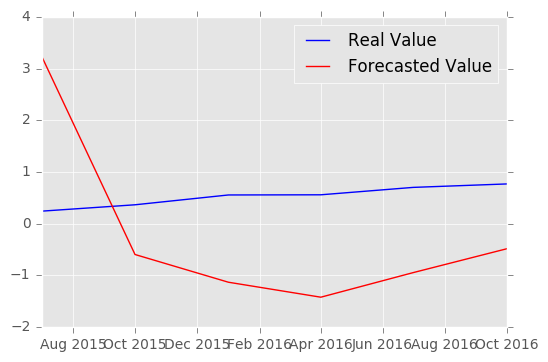

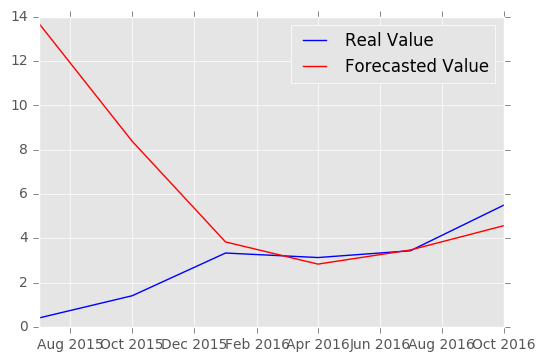

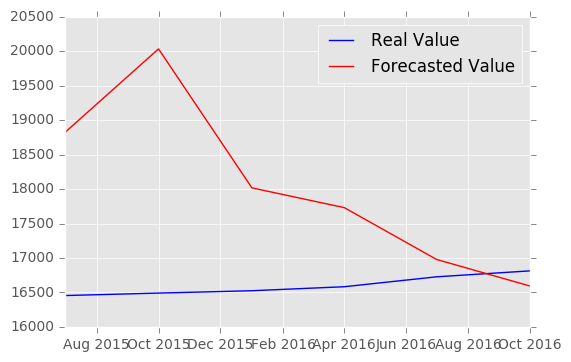

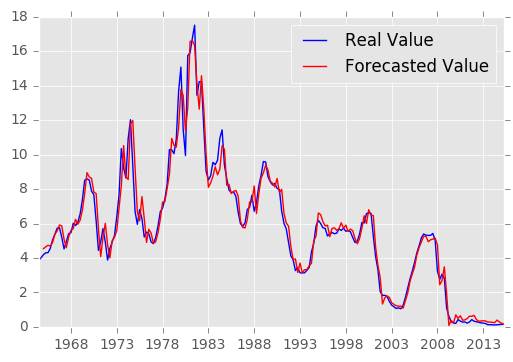

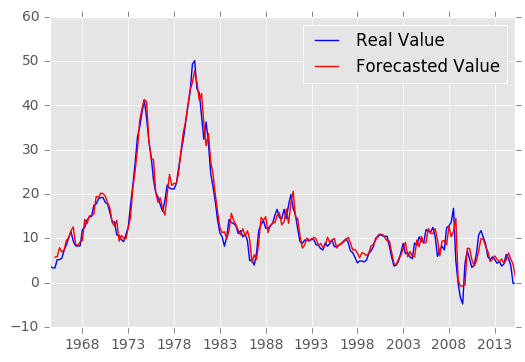

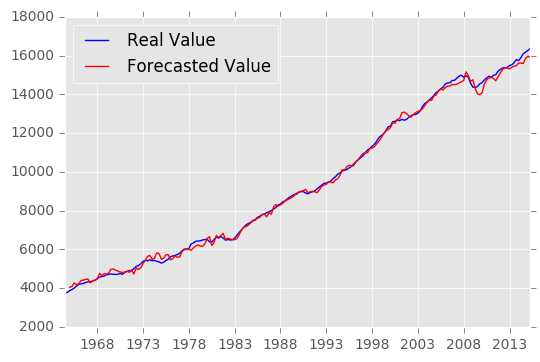

In [115]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [116]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 0.9499
Epoch 2/600
0s - loss: 0.7715
Epoch 3/600
0s - loss: 0.6198
Epoch 4/600
0s - loss: 0.4929
Epoch 5/600
0s - loss: 0.4090
Epoch 6/600
0s - loss: 0.3586
Epoch 7/600
0s - loss: 0.3252
Epoch 8/600
0s - loss: 0.2969
Epoch 9/600
0s - loss: 0.2698
Epoch 10/600
0s - loss: 0.2446
Epoch 11/600
0s - loss: 0.2220
Epoch 12/600
0s - loss: 0.2025
Epoch 13/600
0s - loss: 0.1859
Epoch 14/600
0s - loss: 0.1722
Epoch 15/600
0s - loss: 0.1608
Epoch 16/600
0s - loss: 0.1503
Epoch 17/600
0s - loss: 0.1422
Epoch 18/600
0s - loss: 0.1333
Epoch 19/600
0s - loss: 0.1269
Epoch 20/600
0s - loss: 0.1192
Epoch 21/600
0s - loss: 0.1139
Epoch 22/600
0s - loss: 0.1075
Epoch 23/600
0s - loss: 0.1010
Epoch 24/600
0s - loss: 0.0961
Epoch 25/600
0s - loss: 0.0910
Epoch 26/600
0s - loss: 0.0866
Epoch 27/600
0s - loss: 0.0809
Epoch 28/600
0s - loss: 0.0788
Epoch 29/600
0s - loss: 0.0740
Epoch 30/600
0s - loss: 0.0716
Epoch 31/600
0s - loss: 0.0674
Epoch 32/600
0s - loss: 0.0652
Epoch 33/600
0s -

{'mae': 3.4498268544762438, 'mse': 12.249728961783168, 'rmse': 3.4999612800405617}
{'mae': 8.3482201048249198, 'mse': 100.42151763656797, 'rmse': 10.021053718874477}
{'mae': 770.16257350571448, 'mse': 690086.09654806682, 'rmse': 830.7142087072225}


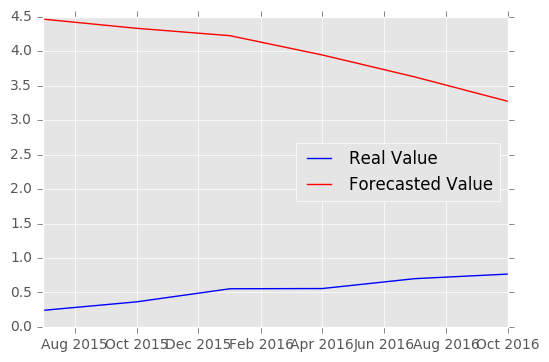

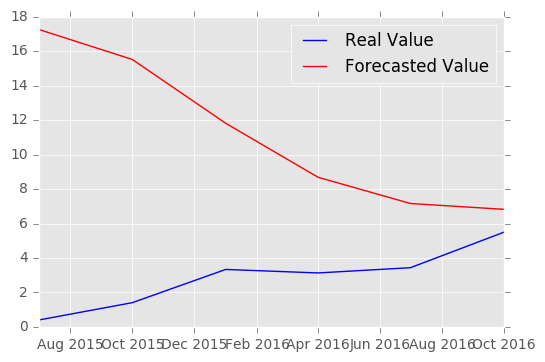

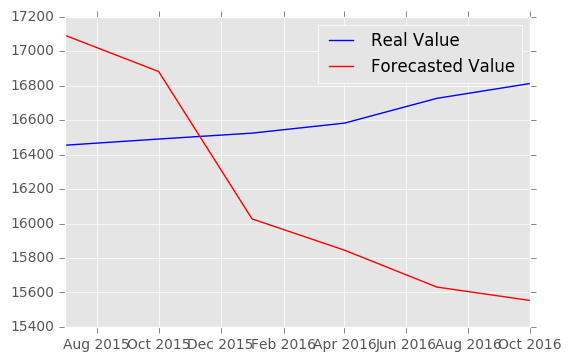

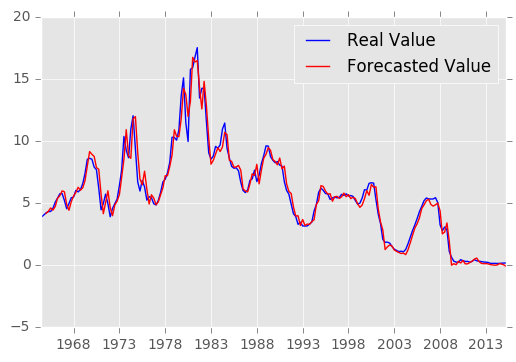

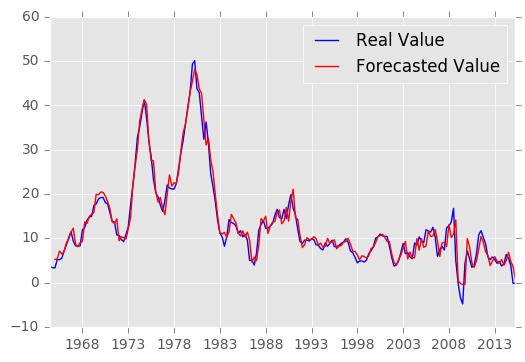

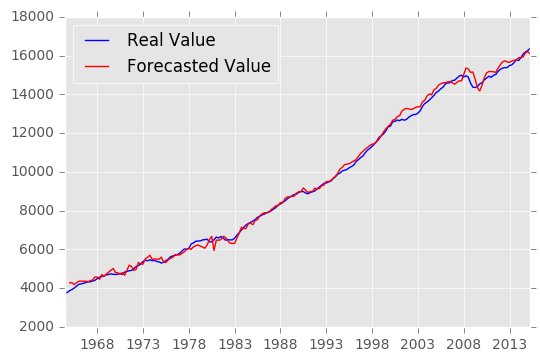

In [117]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [118]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [119]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [120]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1181
Epoch 2/200
0s - loss: 1.0054
Epoch 3/200
0s - loss: 1.0020
Epoch 4/200
0s - loss: 0.9993
Epoch 5/200
0s - loss: 1.0015
Epoch 6/200
0s - loss: 0.9963
Epoch 7/200
0s - loss: 0.9970
Epoch 8/200
0s - loss: 0.9973
Epoch 9/200
0s - loss: 0.9953
Epoch 10/200
0s - loss: 0.9969
Epoch 11/200
0s - loss: 0.9965
Epoch 12/200
0s - loss: 0.9948
Epoch 13/200
0s - loss: 0.9957
Epoch 14/200
0s - loss: 0.9946
Epoch 15/200
0s - loss: 0.9966
Epoch 16/200
0s - loss: 0.9956
Epoch 17/200
0s - loss: 0.9909
Epoch 18/200
0s - loss: 0.9927
Epoch 19/200
0s - loss: 0.9922
Epoch 20/200
0s - loss: 0.9905
Epoch 21/200
0s - loss: 0.9921
Epoch 22/200
0s - loss: 0.9913
Epoch 23/200
0s - loss: 0.9895
Epoch 24/200
0s - loss: 0.9910
Epoch 25/200
0s - loss: 0.9902
Epoch 26/200
0s - loss: 0.9878
Epoch 27/200
0s - loss: 0.9883
Epoch 28/200
0s - loss: 0.9880
Epoch 29/200
0s - loss: 0.9872
Epoch 30/200
0s - loss: 0.9860
Epoch 31/200
0s - loss: 0.9828
Epoch 32/200
0s - loss: 0.9825
Epoch 33/200
0s -

{'mae': 0.35660056927228312, 'mse': 0.33783773173766479, 'rmse': 0.58123810244826934}
{'mae': 1.3697412879164412, 'mse': 2.6206594672403472, 'rmse': 1.6188451029176161}
{'mae': 31.292073653682746, 'mse': 1641.2950456159369, 'rmse': 40.512899743364912}


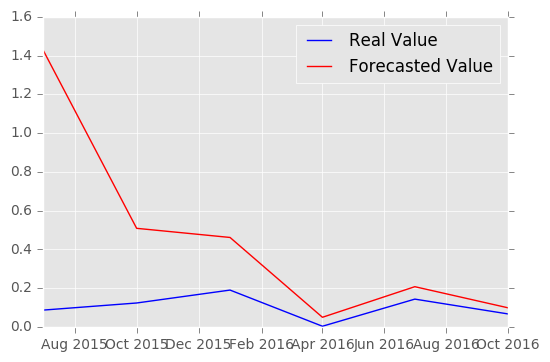

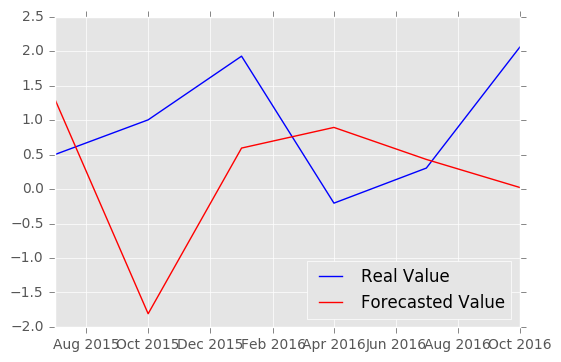

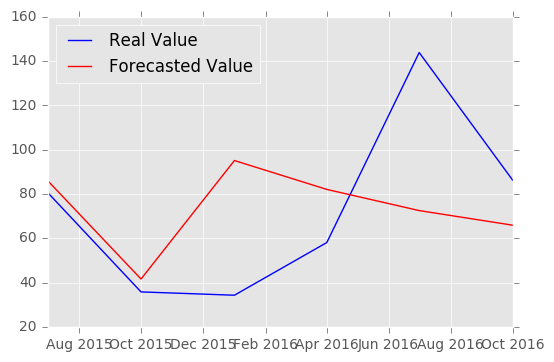

In [121]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 1.8926757584707785, 'mse': 3.6611665109081031, 'rmse': 1.9134174951923333}
{'mae': 2.4428047982370695, 'mse': 7.0879336976167311, 'rmse': 2.6623173547901331}
{'mae': 35.581513169399237, 'mse': 2530.6056858340389, 'rmse': 50.305125840554645}


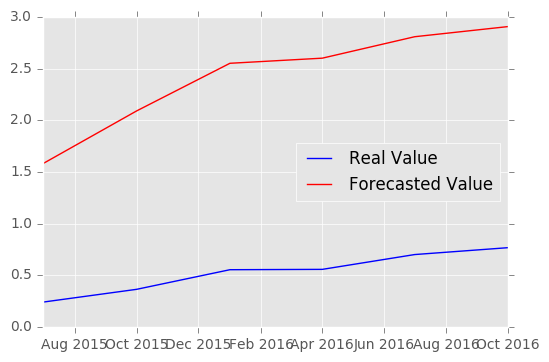

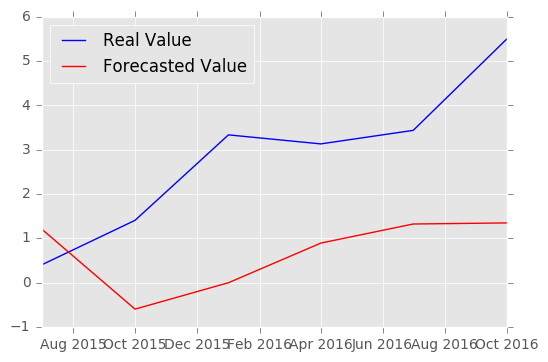

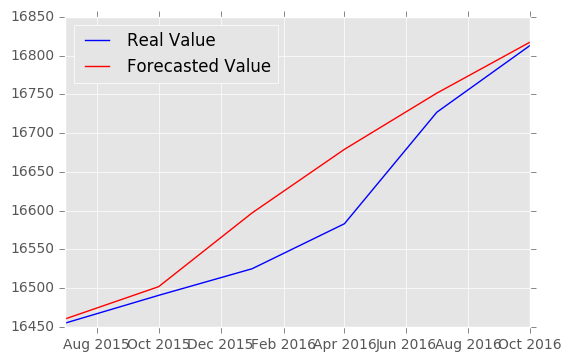

In [122]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [123]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0333
Epoch 2/200
0s - loss: 1.0087
Epoch 3/200
0s - loss: 1.0064
Epoch 4/200
0s - loss: 1.0047
Epoch 5/200
0s - loss: 1.0046
Epoch 6/200
0s - loss: 1.0021
Epoch 7/200
0s - loss: 1.0040
Epoch 8/200
0s - loss: 1.0023
Epoch 9/200
0s - loss: 1.0032
Epoch 10/200
0s - loss: 1.0013
Epoch 11/200
0s - loss: 0.9996
Epoch 12/200
0s - loss: 1.0031
Epoch 13/200
0s - loss: 1.0012
Epoch 14/200
0s - loss: 1.0009
Epoch 15/200
0s - loss: 0.9991
Epoch 16/200
0s - loss: 0.9967
Epoch 17/200
0s - loss: 0.9975
Epoch 18/200
0s - loss: 0.9990
Epoch 19/200
0s - loss: 0.9975
Epoch 20/200
0s - loss: 0.9971
Epoch 21/200
0s - loss: 0.9996
Epoch 22/200
0s - loss: 0.9962
Epoch 23/200
0s - loss: 0.9950
Epoch 24/200
0s - loss: 0.9939
Epoch 25/200
0s - loss: 0.9947
Epoch 26/200
0s - loss: 0.9969
Epoch 27/200
0s - loss: 0.9945
Epoch 28/200
0s - loss: 0.9962
Epoch 29/200
0s - loss: 0.9916
Epoch 30/200
0s - loss: 0.9925
Epoch 31/200
0s - loss: 0.9931
Epoch 32/200
0s - loss: 0.9937
Epoch 33/200
0s -

{'mae': 0.2530961567088304, 'mse': 0.085947916641842717, 'rmse': 0.29316875113463697}
{'mae': 1.0999838178101971, 'mse': 1.7043775200866724, 'rmse': 1.3055181040823112}
{'mae': 33.697916864885848, 'mse': 2101.5666075723711, 'rmse': 45.842846852833773}


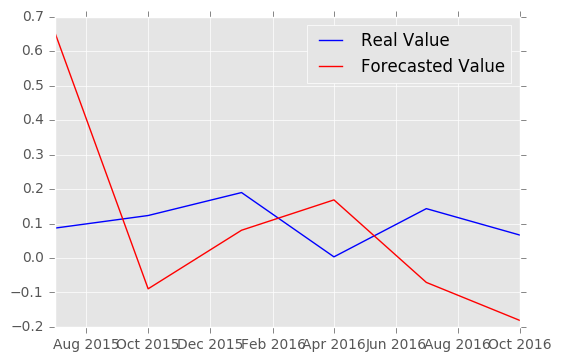

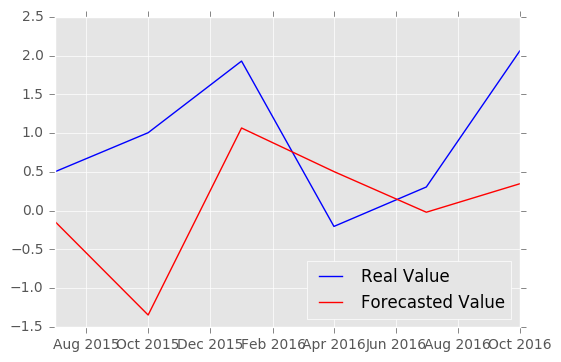

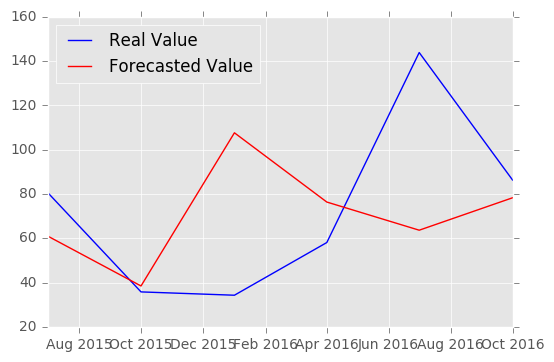

In [124]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.305357831974085, 'mse': 0.12054668659630698, 'rmse': 0.34719833898840441}
{'mae': 3.2138512367719074, 'mse': 12.170430072666454, 'rmse': 3.4886143485152461}
{'mae': 31.1350017474136, 'mse': 1606.7356246959164, 'rmse': 40.08410688409954}


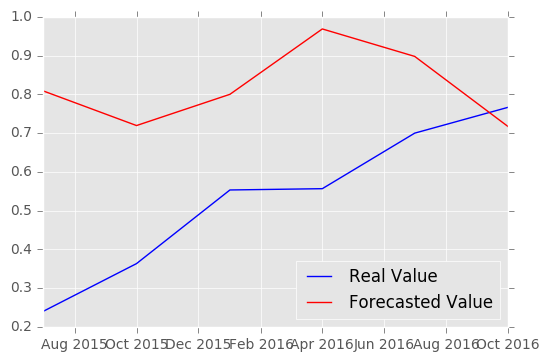

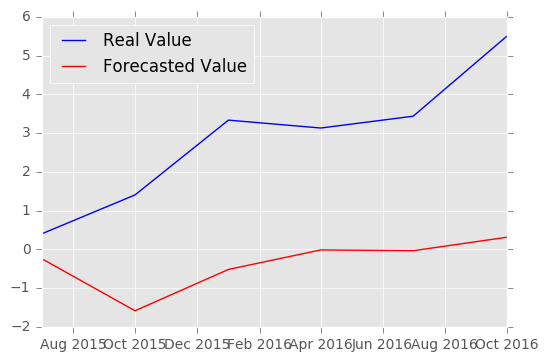

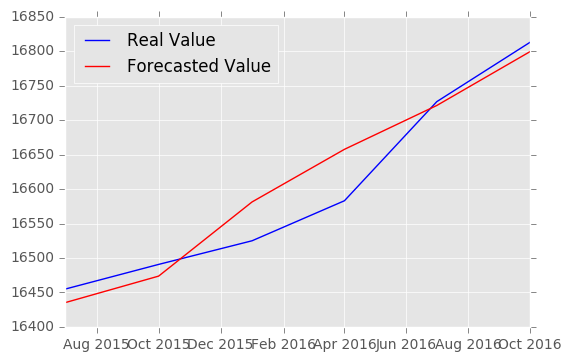

In [125]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [126]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.4181
Epoch 2/200
0s - loss: 1.0431
Epoch 3/200
0s - loss: 1.0167
Epoch 4/200
0s - loss: 1.0047
Epoch 5/200
0s - loss: 1.0151
Epoch 6/200
0s - loss: 1.0093
Epoch 7/200
0s - loss: 1.0055
Epoch 8/200
0s - loss: 1.0293
Epoch 9/200
0s - loss: 1.0072
Epoch 10/200
0s - loss: 1.0148
Epoch 11/200
0s - loss: 1.0029
Epoch 12/200
0s - loss: 1.0007
Epoch 13/200
0s - loss: 1.0082
Epoch 14/200
0s - loss: 0.9950
Epoch 15/200
0s - loss: 1.0052
Epoch 16/200
0s - loss: 1.0233
Epoch 17/200
0s - loss: 0.9997
Epoch 18/200
0s - loss: 1.0115
Epoch 19/200
0s - loss: 0.9999
Epoch 20/200
0s - loss: 0.9992
Epoch 21/200
0s - loss: 1.0204
Epoch 22/200
0s - loss: 0.9994
Epoch 23/200
0s - loss: 0.9930
Epoch 24/200
0s - loss: 1.0039
Epoch 25/200
0s - loss: 1.0002
Epoch 26/200
0s - loss: 0.9950
Epoch 27/200
0s - loss: 1.0049
Epoch 28/200
0s - loss: 0.9974
Epoch 29/200
0s - loss: 0.9890
Epoch 30/200
0s - loss: 1.0183
Epoch 31/200
0s - loss: 0.9976
Epoch 32/200
0s - loss: 0.9901
Epoch 33/200
0s -

{'mae': 0.10000146721346546, 'mse': 0.011811353135197974, 'rmse': 0.10868004938901148}
{'mae': 0.97601740078611876, 'mse': 1.5948609779939253, 'rmse': 1.2628780534928641}
{'mae': 34.624982812070698, 'mse': 1722.2229279936003, 'rmse': 41.499673829966426}


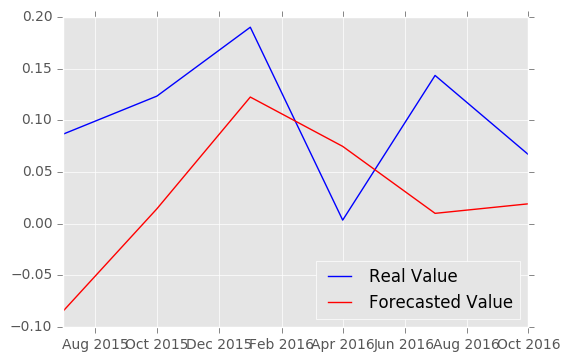

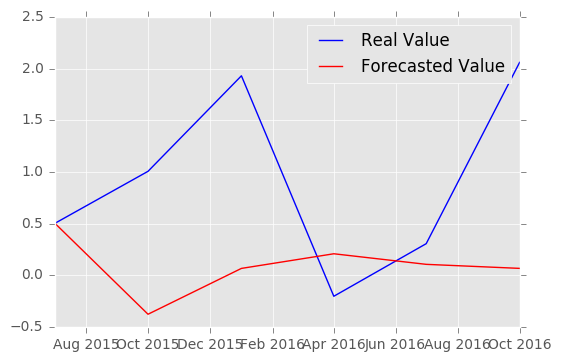

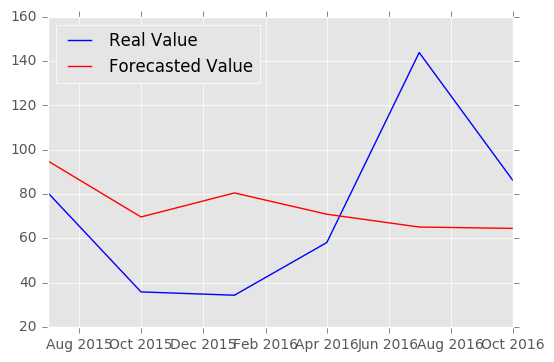

In [127]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 0.32367789029290567, 'mse': 0.11364944809107307, 'rmse': 0.33711933805564026}
{'mae': 2.5852465384355039, 'mse': 9.1427770064888954, 'rmse': 3.0237025327384464}
{'mae': 49.796120841131291, 'mse': 3957.7021896411966, 'rmse': 62.910270939181281}


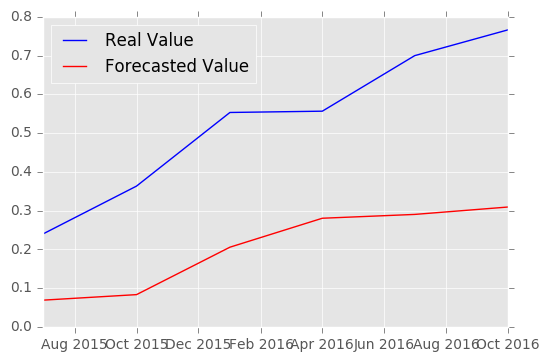

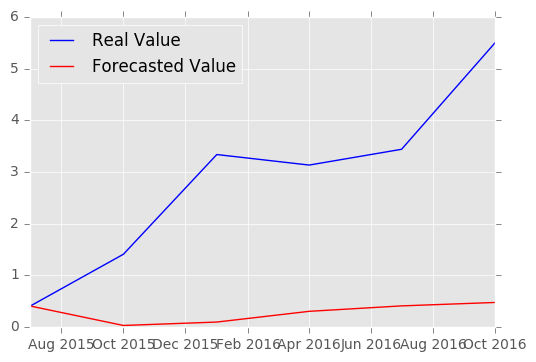

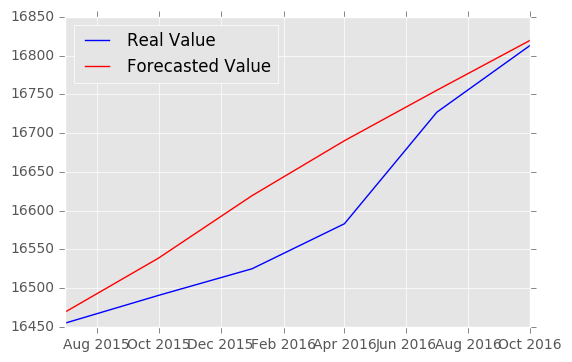

In [128]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid Full

In [129]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [130]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0406
Epoch 2/500
0s - loss: 0.7942
Epoch 3/500
0s - loss: 0.6349
Epoch 4/500
0s - loss: 0.4936
Epoch 5/500
0s - loss: 0.3945
Epoch 6/500
0s - loss: 0.3366
Epoch 7/500
0s - loss: 0.3047
Epoch 8/500
0s - loss: 0.2819
Epoch 9/500
0s - loss: 0.2631
Epoch 10/500
0s - loss: 0.2447
Epoch 11/500
0s - loss: 0.2295
Epoch 12/500
0s - loss: 0.2172
Epoch 13/500
0s - loss: 0.2044
Epoch 14/500
0s - loss: 0.1946
Epoch 15/500
0s - loss: 0.1853
Epoch 16/500
0s - loss: 0.1783
Epoch 17/500
0s - loss: 0.1709
Epoch 18/500
0s - loss: 0.1640
Epoch 19/500
0s - loss: 0.1567
Epoch 20/500
0s - loss: 0.1508
Epoch 21/500
0s - loss: 0.1456
Epoch 22/500
0s - loss: 0.1385
Epoch 23/500
0s - loss: 0.1329
Epoch 24/500
0s - loss: 0.1281
Epoch 25/500
0s - loss: 0.1230
Epoch 26/500
0s - loss: 0.1191
Epoch 27/500
0s - loss: 0.1144
Epoch 28/500
0s - loss: 0.1109
Epoch 29/500
0s - loss: 0.1093
Epoch 30/500
0s - loss: 0.1055
Epoch 31/500
0s - loss: 0.1035
Epoch 32/500
0s - loss: 0.1018
Epoch 33/500
0s -

{'mae': 5.8403041119124879, 'mse': 36.711420677822879, 'rmse': 6.0589950220991993}
{'mae': 4.8996328590870641, 'mse': 26.600648730854431, 'rmse': 5.1575816746663774}
{'mae': 134.40525402525358, 'mse': 61578.469303416874, 'rmse': 248.15009430467052}


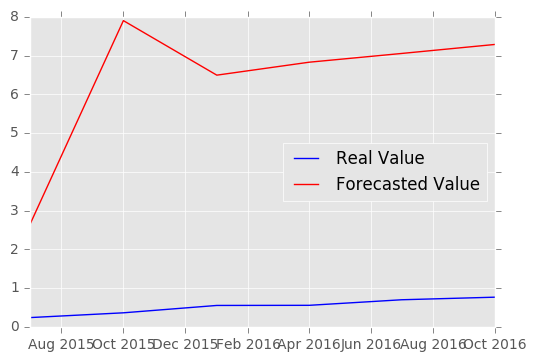

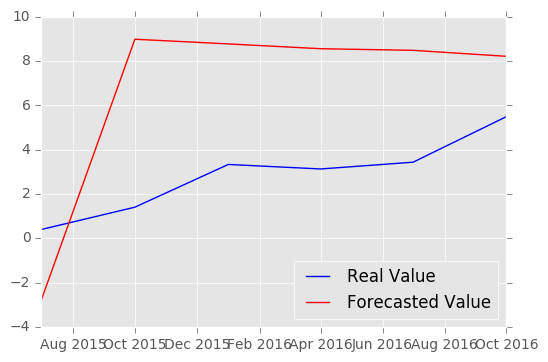

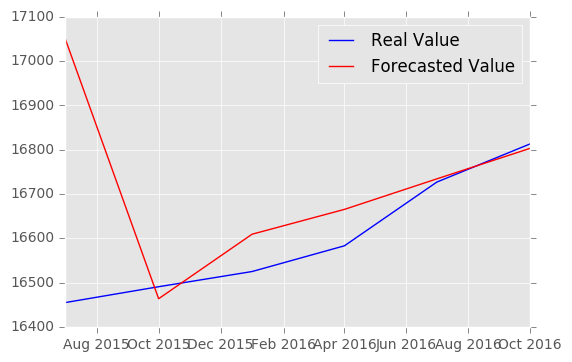

In [131]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [132]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 0.9729
Epoch 2/500
0s - loss: 0.7964
Epoch 3/500
0s - loss: 0.6618
Epoch 4/500
0s - loss: 0.5300
Epoch 5/500
0s - loss: 0.4236
Epoch 6/500
0s - loss: 0.3531
Epoch 7/500
0s - loss: 0.3149
Epoch 8/500
0s - loss: 0.2854
Epoch 9/500
0s - loss: 0.2616
Epoch 10/500
0s - loss: 0.2412
Epoch 11/500
0s - loss: 0.2258
Epoch 12/500
0s - loss: 0.2113
Epoch 13/500
0s - loss: 0.2018
Epoch 14/500
0s - loss: 0.1930
Epoch 15/500
0s - loss: 0.1863
Epoch 16/500
0s - loss: 0.1802
Epoch 17/500
0s - loss: 0.1738
Epoch 18/500
0s - loss: 0.1693
Epoch 19/500
0s - loss: 0.1634
Epoch 20/500
0s - loss: 0.1582
Epoch 21/500
0s - loss: 0.1526
Epoch 22/500
0s - loss: 0.1481
Epoch 23/500
0s - loss: 0.1428
Epoch 24/500
0s - loss: 0.1371
Epoch 25/500
0s - loss: 0.1340
Epoch 26/500
0s - loss: 0.1278
Epoch 27/500
0s - loss: 0.1240
Epoch 28/500
0s - loss: 0.1199
Epoch 29/500
0s - loss: 0.1154
Epoch 30/500
0s - loss: 0.1129
Epoch 31/500
0s - loss: 0.1091
Epoch 32/500
0s - loss: 0.1058
Epoch 33/500
0s -

{'mae': 0.67878720489888655, 'mse': 0.4792980293029645, 'rmse': 0.69231353395911921}
{'mae': 0.93193977809986084, 'mse': 1.0828350084365772, 'rmse': 1.0405935846604943}
{'mae': 307.52992882626069, 'mse': 109680.63725253013, 'rmse': 331.18067161676288}


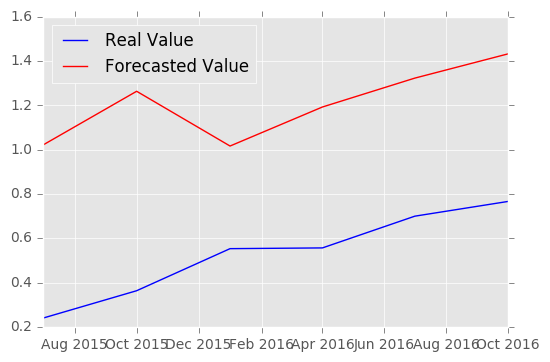

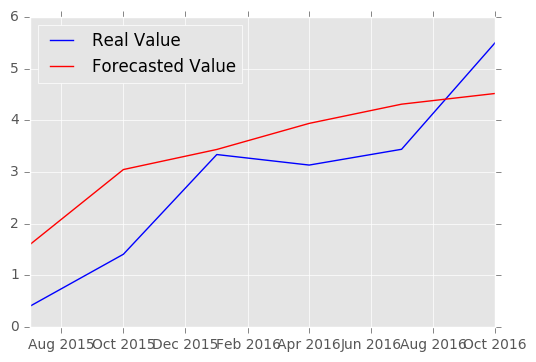

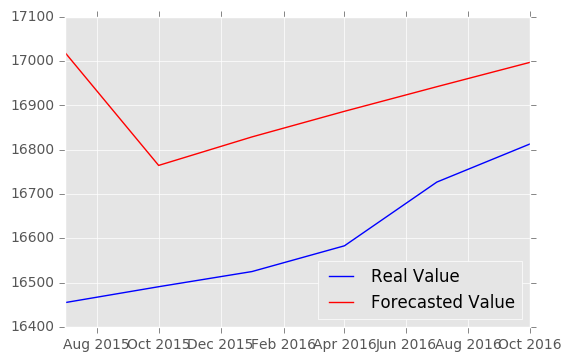

In [133]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [134]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0764
Epoch 2/500
0s - loss: 1.0139
Epoch 3/500
0s - loss: 1.0075
Epoch 4/500
0s - loss: 0.9898
Epoch 5/500
0s - loss: 0.9758
Epoch 6/500
0s - loss: 0.9819
Epoch 7/500
0s - loss: 0.9707
Epoch 8/500
0s - loss: 0.9526
Epoch 9/500
0s - loss: 0.9306
Epoch 10/500
0s - loss: 0.8461
Epoch 11/500
0s - loss: 0.8154
Epoch 12/500
0s - loss: 0.7568
Epoch 13/500
0s - loss: 0.7354
Epoch 14/500
0s - loss: 0.6704
Epoch 15/500
0s - loss: 0.6300
Epoch 16/500
0s - loss: 0.6012
Epoch 17/500
0s - loss: 0.5736
Epoch 18/500
0s - loss: 0.5881
Epoch 19/500
0s - loss: 0.5694
Epoch 20/500
0s - loss: 0.5560
Epoch 21/500
0s - loss: 0.5520
Epoch 22/500
0s - loss: 0.5908
Epoch 23/500
0s - loss: 0.5558
Epoch 24/500
0s - loss: 0.5010
Epoch 25/500
0s - loss: 0.5359
Epoch 26/500
0s - loss: 0.5345
Epoch 27/500
0s - loss: 0.5124
Epoch 28/500
0s - loss: 0.5117
Epoch 29/500
0s - loss: 0.4958
Epoch 30/500
0s - loss: 0.5354
Epoch 31/500
0s - loss: 0.5332
Epoch 32/500
0s - loss: 0.5327
Epoch 33/500
0s -

{'mae': 1.9055256154465903, 'mse': 3.6395475908071488, 'rmse': 1.9077598357254377}
{'mae': 1.526443828815591, 'mse': 3.2551935372536662, 'rmse': 1.8042154908030432}
{'mae': 136.91724805122735, 'mse': 20288.399850314636, 'rmse': 142.43735412564584}


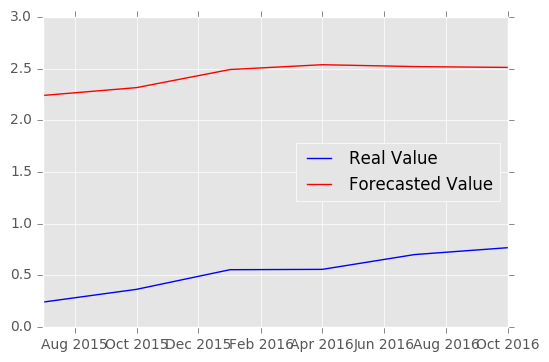

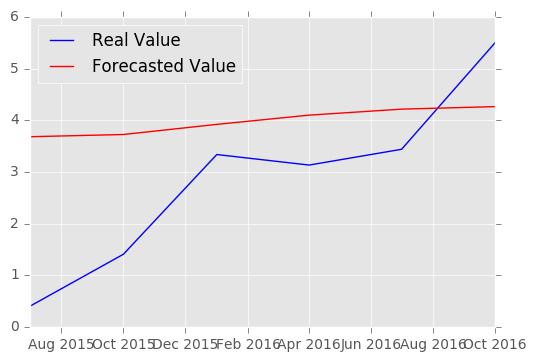

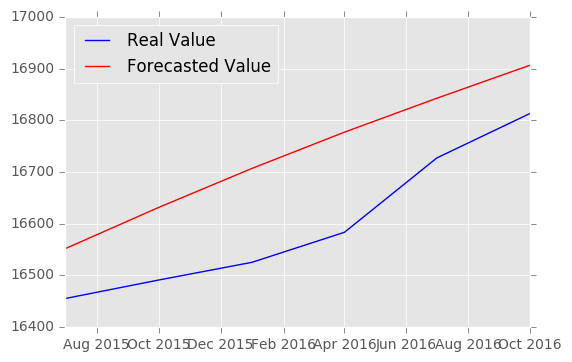

In [135]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])